Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle

import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
# !ls ../output/pickle_results/real_data/

In [3]:
# path = "../"

# category = "real_data"

# scDeepCluster = pd.read_pickle(
#     f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
# scDeepCluster1 = pd.read_pickle(
#     f"../output/pickle_results/{category}/{category}_scDeepCluster (copy).pkl")

# pd.concat([
#     scDeepCluster, scDeepCluster1[scDeepCluster1.dataset == "Quake_10x_Spleen"]
# ]).to_pickle(
#     f"../output/pickle_results/{category}/{category}_scDeepCluster1.pkl")

In [4]:
# scvi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scvi.pkl")
# scvi

In [5]:
for category in [ "real_data",
                 "imbalanced_data", "balanced_data",
                ]:

    df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline.pkl")
#     df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari"].mean().unstack(["layers", "lr"])

    df_k = df[[
        'dataset',
        'dropout',
        'kmeans_ari',
        'kmeans_nmi',
        'kmeans_sil',
        'kmeans_cal',
        'run',
        "t_k",
        'kmeans_pred',
    ]].rename(columns={
        'kmeans_ari': "ARI",
        'kmeans_nmi': "NMI",
        'kmeans_pred': 'pred',
        'kmeans_sil': "sil",
        'kmeans_cal': "cal",
        't_k': 'time'
    })
    df_k["method"] = "constrastive+KM"

    df_l = df[[
        'dataset',
        'dropout',
        'leiden_ari',
        'leiden_nmi',
        'leiden_sil',
        'leiden_cal',
        'run',
        't_l',
        'leiden_pred',
    ]].rename(columns={
        'leiden_ari': "ARI",
        'leiden_nmi': "NMI",
        'leiden_pred': 'pred',
        'leiden_sil': "sil",
        'leiden_cal': "cal",
        't_l': 'time'
    })

    df_l["method"] = "constrastive+LD"

    r_data = pd.read_pickle(f"../R/{category}.pkl")

    if category == "real_data":
        scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster1.pkl")
    else: 
        scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
    scDeepCluster["method"] = "scDeepCluster"

    sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
    sczi["method"] = "scziDesk"

    scedar = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scedar.pkl")
    scedar["method"] = "scedar"

    scanpy = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scanpy.pkl")
    scanpy["method"] = "scanpy-seurat"

    scrna = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scrna.pkl")
    scrna["method"] = "scrna"

    pca_kmeans = pd.read_pickle(f"../output/pickle_results/{category}/{category}_pca_kmeans.pkl")
    pca_kmeans["method"] = "pca_kmeans"
    
    scvi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scvi.pkl")
    scvi["method"] = "scvi"
    

    desc = pd.read_pickle(f"../output/pickle_results/{category}/{category}_desc.pkl")
    desc["pred"] = desc["pred"].apply(lambda x: x.to_list())
    desc["method"] = "desc"

    all_data = pd.concat([df_k, df_l, r_data, desc,pca_kmeans, sczi, 
                          scDeepCluster ,scedar, scanpy, scvi, scrna])
    all_data = all_data.reset_index(drop = True)

    all_data = all_data.rename(columns={"sil": "Silhouette", "cal": "Calinski"})

    path = ".."
    if category in ["balanced_data", "imbalanced_data"]:
        files = glob2.glob(f'{path}/R/simulated_data/{category}/*.h5')
        files = [f[len(f"{path}/R/simulated_data/{category}/"):-3] for f in files]
    else:
        files = glob2.glob(f'{path}/real_data/*.h5')
        files = [f[len(f"{path}/real_data/"):-3] for f in files]
    print(files)


    if category in ["imbalanced_data", "balanced_data"]:
        sc_dropout = {
            'data_1c8': 0.3,
            'data_-1c4': 0.08,
            'data_-1c8': 0.08,
            'data_0c4': 0.17,
            'data_0c8': 0.17,
            'data_0c16': 0.17,
            'data_1.5c4': 0.38,
            'data_1c4': 0.3,
            'data_1.5c8': 0.38,
            'data_1.5c16': 0.38,
            'data_-1c16': 0.08,
            'data_1c16': 0.3,
            'data_0c32': 0.17,
            'data_1.5c32': 0.38,
            'data_1c32': 0.3,
            'data_-1c32': 0.08
        }
        all_data["dropout"] = all_data["dataset"].apply(lambda x: sc_dropout[x])
        all_data["nb_clust"]= all_data["dataset"].apply(lambda x: int(x.split("c")[1]))
    ordered_methods = [
        'constrastive+KM',
        'scziDesk',
        'scDeepCluster',
        'scrna',
        'cidr',
        'soup',
        'pca_kmeans',
        'constrastive+LD',
        'desc',
        'scanpy-seurat',
        'scedar',
        'scvi',
        'raceid',  
    ]
    ordered_methods = dict(zip(ordered_methods, np.arange(len(ordered_methods))))

    all_data["order"] = all_data["method"].apply(lambda x: ordered_methods[x])

    all_data.to_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm', 'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam', 'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung', 'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell', 'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC']
['data_1c8', 'data_-1c4', 'data_-1c8', 'data_0c4', 'data_0c8', 'data_0c16', 'data_1.5c4', 'data_1c4', 'data_1.5c8', 'data_1.5c16', 'data_-1c16', 'data_1c16']
['data_1c8', 'data_-1c4', 'data_-1c8', 'data_0c4', 'data_0c8', 'data_0c16', 'data_1.5c4', 'data_1c4', 'data_1.5c8', 'data_1.5c16', 'data_-1c16', 'data_1c16']


In [6]:
methods_no_clust = [
    'constrastive+LD',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]

In [7]:
category = "imbalanced_data"
# category = "balanced_data"
# category = "real_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

# all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
# all_data["nb_pred_clust"] = all_data.apply(lambda x: x["nb_pred_clust"]/x["nb_clust"], axis = 1)

In [8]:
# all_data[all_data["method"] == "desc"]

In [9]:
import seaborn as sns
ordered_methods = [
    'constrastive+KM',
    'scziDesk',
    'scDeepCluster',
    'scrna',
    'cidr',
    'soup',
    'pca_kmeans',
    'constrastive+LD',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]
clrs = ['#C0392B', "#F1948A", "#D7BDE2", "#8E44AD", "#7FB3D5", "#2874A6", "#76D7C4", "#117A65",
        '#00ff00',
        "#F1C40F", "#EB984E", "#839192", "#566573"
       ]
len(clrs)

13

In [ ]:
# category = "imbalanced_data"
# all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
# rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
# rank = rank.rank(ascending=False, method = "min")
# rankKM = rank.T["constrastive+KM"]
# rankLD = rank.T["constrastive+LD"]
# rankKM

# rank = pd.concat([rankKM, rankLD], axis = 1)

# rank["rank"] = rank.apply(lambda x: min(x.values), axis = 1)

# rank = rank["rank"] 
# rank

# Simulated methods Comparaision

# Per datasets

In [ ]:
plt.figure(figsize = (14, 13))
nrows = 4
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]

ax = plt.subplot(nrows, 1, 1)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[:6]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking

for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend(bbox_to_anchor=(0, 1.35), loc=2, borderaxespad=0., ncol=7)
# plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a1) ARI per dataset - Balanced data", fontweight = "bold")


ax = plt.subplot(nrows, 1, 2)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[6:]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.9, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a2)  ARI per dataset - Balanced data", fontweight = "bold")

###############################################

category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]

ax = plt.subplot(nrows, 1, 3)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[:6]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking

for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
# plt.legend(bbox_to_anchor=(0, 1.35), loc=2, borderaxespad=0., ncol=7)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(b1) ARI per dataset - Imbalanced data", fontweight = "bold")


ax = plt.subplot(nrows, 1, 4)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[6:]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.7, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(b2)  ARI per dataset - Imbalanced data", fontweight = "bold")

plt.tight_layout()
plt.savefig(f"../diagrams/simulated_per_datasets.pdf", bbox_inches='tight')

# Overall simulated

In [ ]:
plt.figure(figsize = (13, 8))
nrows = 2
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)


ax = plt.subplot(nrows, 3, 1)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)

# for i in range(7,13):
#     plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(a) ARI Balanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
##
ax = plt.subplot(nrows, 3, 2)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)
# for i in range(7,13):
#     plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(b) Silhouette Balanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()

ax = plt.subplot(nrows, 3, 3)
sns.boxplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)
plt.xticks(rotation = 90)
plt.ylabel("Error nb pred clusters")
sns.despine()
plt.title(f"(c) Error predicted nb clusters (balanced)", fontweight = "bold")
plt.xlabel("")

plt.text(-0.4, 1.9, "2x more clusters")
plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
###############################################

category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)

ax = plt.subplot(nrows, 3, 4)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)

# for i in range(7,13):
#     plt.text(i, 0.60, "*")
plt.xlabel("")
plt.title("(d) ARI Imbalanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
##
ax = plt.subplot(nrows, 3, 5)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)
# for i in range(7,13):
#     plt.text(i, 0.60, "*")
plt.xlabel("")
plt.title("(e) Silhouette Imbalanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()

ax = plt.subplot(nrows, 3, 6)
sns.boxplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)
plt.xticks(rotation = 90)
plt.ylabel("Error nb pred clusters")
sns.despine()
plt.title(f"(f) Error predicted nb clusters (imbalanced)", fontweight = "bold")
plt.xlabel("")

plt.text(-0.4, 3.9, "4x more clusters")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/simulated_overall.pdf", bbox_inches='tight')

# Overview real methods

In [10]:
category = "real_data"
desc = pd.read_excel("../output/pickle_results/real_data/description.xlsx")
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data = pd.merge(all_data, desc[["dataset", "nb_clusters"]], on = "dataset")
all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clusters"])/x["nb_clusters"], 
                                           axis = 1)

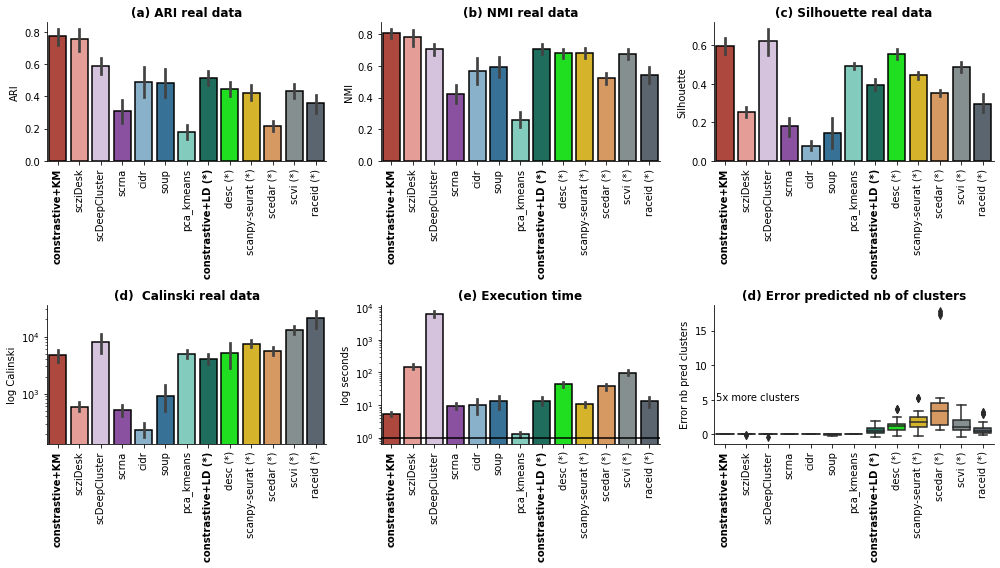

In [11]:
plt.figure(figsize=(14, 8))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["real data"]
nb_rows=2
i = 0
ax = plt.subplot(nb_rows,3,i*4 +1)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title(f"{letters[i*4]} ARI {titles[i]}", fontweight = "bold")
plt.xlabel("")
sns.despine()
# for j in range(7,13):
#     plt.text(j, 0.7, "*")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 

ax = plt.subplot(nb_rows,3,i*4 +2)
sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.xlabel("")
plt.title(f"{letters[i*4 +1]} NMI {titles[i]}", fontweight = "bold")
# for j in range(7,13):
#     plt.text(j, 0.8, "*")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 

ax = plt.subplot(nb_rows,3,i*4 +3)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title(f"{letters[i*4 +2]} Silhouette {titles[i]}", fontweight = "bold")
plt.xlabel("")
# for j in range(7,13):
#     plt.text(j, 0.6, "*")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()

## Nb predicted clusters
ax = plt.subplot(nb_rows,3,i*4 +4)
g= sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
g.set(yscale="log")
plt.xticks(rotation = 90)
plt.ylabel("log Calinski")
plt.title(f"{letters[i*4 +3]}  Calinski {titles[i]}", fontweight = "bold")
plt.xlabel("")
# for j in range(7,13):
#     plt.text(j, 20000, "*")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
    
    
ax = plt.subplot(nb_rows, 3, 5)
g = sns.barplot(x = "method", y="time", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
           linewidth=1.5
           )
g.set(yscale="log")
plt.axhline(y=1, c = "black")
plt.ylabel("log seconds")
plt.xticks(rotation = 90)
# for j in range(7,13):
#     plt.text(j, 3000, "*")
plt.title(f"(e) Execution time", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
plt.xlabel("")


ax = plt.subplot(nb_rows, 3, 6)
sns.boxplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)
plt.xticks(rotation = 90)
plt.ylabel("Error nb pred clusters")
sns.despine()
plt.title(f"(d) Error predicted nb of clusters", fontweight = "bold")
plt.xlabel("")

plt.text(-0.4, 4.9, "5x more clusters")
# plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()

plt.tight_layout()
plt.savefig(f"../diagrams/real.pdf", bbox_inches='tight')

In [ ]:
# titles = ["(a)", "(b)", "(c)", "(d)"]
# plt.figure(figsize = (12, 12))
# category = "balanced_data"
# all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

# for i, dropout in enumerate(sorted(all_data.dropout.unique())):
#     ax = plt.subplot(4, 2, i+1)
#     sns.barplot(x = "nb_clust", y="ARI", 
#                 data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
#                 hue = "method",
#                palette=clrs,
#                edgecolor='black',
#         linewidth=1.5)

#     plt.title(f"{titles[i]} Balanced data, dropout rate {dropout} %")
#     if i ==1:
#         plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
# #         plt.legend(bbox_to_anchor=(0., 1.4), loc=2, borderaxespad=0., ncol=7)
#     else: 
#         plt.legend([],[], frameon=False)

#     plt.xlabel("")
#     sns.despine()
    
    
# category = "imbalanced_data"
# all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
# titles = ["(e)", "(f)", "(g)", "(g)"]
# for i, dropout in enumerate(sorted(all_data.dropout.unique())):
#     ax = plt.subplot(4, 2, i+5)
#     sns.barplot(x = "nb_clust", y="ARI", 
#                 data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
#                 hue = "method",
#                palette=clrs,
#                edgecolor='black',
#         linewidth=1.5)

#     plt.title(f"{titles[i]} Imbalanced data, dropout rate {dropout} %")

#     plt.legend([],[], frameon=False)
#     if i in [2, 3]:
#         plt.xlabel("Nb. of clusters")
#     else:
#         plt.xlabel("")
#     sns.despine()
# plt.tight_layout()
# plt.savefig(f"../diagrams/{category}_barplot_by_dropout.pdf", bbox_inches='tight')

In [ ]:
# titles = ["(a)", "(b)", "(c)", "(d)"]
# plt.figure(figsize = (12, 5))
# for i, dropout in enumerate(sorted(all_data.dropout.unique())):
#     ax = plt.subplot(2, 2, i+1)
#     sns.barplot(x = "nb_clust", y="ARI", 
#                 data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
#                 hue = "method",
#                palette=clrs,
#                edgecolor='black',
#         linewidth=1.5)

#     plt.title(f"{titles[i]} dropout rate {dropout} %")
#     if i ==1:
#         plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
#     else: 
#         plt.legend([],[], frameon=False)
#     if i in [2, 3]:
#         plt.xlabel("Nb. of clusters")
#     else:
#         plt.xlabel("")
#     sns.despine()
# # plt.tight_layout()
# plt.savefig(f"../diagrams/{category}_barplot_by_dropout.pdf", bbox_inches='tight')

# Overview all methods

In [ ]:
plt.figure(figsize=(14, 12))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["balanced data", "imbalanced data", "real data"]
for i, category in enumerate (["balanced_data", "imbalanced_data", "real_data"] ):
    all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
    all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
    ax = plt.subplot(3,4,i*4 +1)
    sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_xticklabels()[0].set_fontweight('bold') 
    plt.gca().get_xticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4]} ARI {titles[i]}", fontweight = "bold")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +2)
    sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_xticklabels()[0].set_fontweight('bold') 
    plt.gca().get_xticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.xlabel("")
    plt.title(f"{letters[i*4 +1]} NMI {titles[i]}", fontweight = "bold")

    ax = plt.subplot(3,4,i*4 +3)
    sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_xticklabels()[0].set_fontweight('bold') 
    plt.gca().get_xticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +2]} Silhouette {titles[i]}", fontweight = "bold")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +4)
    g= sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_xticklabels()[0].set_fontweight('bold') 
    plt.gca().get_xticklabels()[7].set_fontweight('bold')
    g.set(yscale="log")
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +3]}  Calinski {titles[i]}", fontweight = "bold")
    plt.xlabel("")
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/all_barplot.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize = (20, 13))
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dp: {x['dropout']}\n{x['nb_clust']} clust", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: x["nb_pred_clust"]/x["nb_clust"], axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]
ax = plt.subplot(411)
sns.barplot(x = "label", y="ARI", 
                data = all_data.sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.98, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend(bbox_to_anchor=(0, 1.45), loc=2, borderaxespad=0., ncol=10, fontsize=13)
sns.despine()
plt.xlabel("")
plt.title("(a) Detailed Balanced data")

ax = plt.subplot(425)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
for i in range(7,13):
    plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(c) Average Balanced data")
ax = plt.subplot(427)
sns.barplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(fontsize=13,  rotation = 70)
plt.axhline(y=1, c = "black")
plt.ylabel("Nb predicted clusters")
sns.despine()
for i in range(7,13):
    plt.text(i, 2, "*")
plt.title(f"(e)Balanced data - Nb predicted clusters precision")
plt.xlabel("")
sns.despine()
###########################################
category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dp: {x['dropout']}\n{x['nb_clust']} clust", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: x["nb_pred_clust"]/x["nb_clust"], axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]

ax = plt.subplot(412)
sns.barplot(x = "label", y="ARI", 
                data = all_data.sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
# Ranking
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.96, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
    
plt.legend([])
sns.despine()
plt.xlabel("")
plt.xticks(fontsize=13)
plt.title("(b) Detailed Imbalanced data")
ax = plt.subplot(426)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
for i in range(7,13):
    plt.text(i, 0.72, "*")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.xticks(fontsize=13, rotation = 70)
plt.title(f"(d)Average Imbalanced data")
plt.xlabel("")
sns.despine()

ax = plt.subplot(428)
sns.barplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
           linewidth=1.5
           )
plt.axhline(y=1, c = "black")
plt.ylabel("Nb predicted clusters ")
plt.xticks(fontsize=13,  rotation = 70)
for i in range(7,13):
    plt.text(i, 4, "*")
plt.title(f"(f)Imbalanced data - Nb predicted clusters precision")
sns.despine()
plt.xlabel("")
plt.tight_layout()
plt.savefig(f"../diagrams/simulated.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize = (13, 11))
nrows = 3
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]

ax = plt.subplot(nrows, 1, 1)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[:6]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking

for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend(bbox_to_anchor=(0, 1.35), loc=2, borderaxespad=0., ncol=7)
# plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a1) ARI per dataset - Balanced data", fontweight = "bold")


ax = plt.subplot(nrows, 1, 2)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[6:]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.9, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a2)  ARI per dataset - Balanced data", fontweight = "bold")

####
ax = plt.subplot(nrows, 3, 7)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)

for i in range(7,13):
    plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(b) ARI Balanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
##
ax = plt.subplot(nrows, 3, 8)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)
for i in range(7,13):
    plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(c) Silhouette Balanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()

ax = plt.subplot(nrows, 3, 9)
sns.boxplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)
plt.xticks(rotation = 90)
plt.ylabel("Error nb pred clusters")
sns.despine()
plt.title(f"(d) Error predicted nb clusters", fontweight = "bold")
plt.xlabel("")

plt.text(-0.4, 1.9, "2x more clusters")
plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
###############################################
plt.tight_layout()
plt.savefig(f"../diagrams/balanced.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize = (13, 11))
nrows = 3
category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]

ax = plt.subplot(nrows, 1, 1)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[:6]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking

for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend(bbox_to_anchor=(0, 1.35), loc=2, borderaxespad=0., ncol=7)
# plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a1) ARI per dataset - Imbalanced data", fontweight = "bold")


ax = plt.subplot(nrows, 1, 2)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[6:]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.7, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a2)  ARI per dataset - Imbalanced data", fontweight = "bold")

####
ax = plt.subplot(nrows, 3, 7)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)

for i in range(7,13):
    plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(b) ARI Imbalanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
##
ax = plt.subplot(nrows, 3, 8)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
plt.xticks(rotation  = 90)
for i in range(7,13):
    plt.text(i, 0.80, "*")
plt.xlabel("")
plt.title("(c) Silhouette Imbalanced data", fontweight = "bold")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()

ax = plt.subplot(nrows, 3, 9)
sns.boxplot(x = "method", y="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)
plt.xticks(rotation = 90)
plt.ylabel("Error nb pred clusters")
sns.despine()
plt.title(f"(e) Error predicted nb clusters", fontweight = "bold")
plt.xlabel("")

plt.text(-0.4, 3.9, "4x more clusters")
plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
sns.despine()
###############################################
plt.tight_layout()
plt.savefig(f"../diagrams/imbalanced.pdf", bbox_inches='tight')